In [ ]:
import os
import time
import math
import copy
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F

import random
from typing import List, Tuple
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from common import *
from dataset import *
from model import *

In [ ]:
from utils.dataset import dataset
from utils.common import *
from model import FSRCNN
import argparse
import torch
import os

In [11]:
SCALE = 2

sigma = 0.3 if SCALE == 2 else 0.2

ckpt_path = f"checkpoint/x{SCALE}/FSRCNN-x{SCALE}.pt"

In [12]:
image_path_base = "dataset/validation"

device = "cuda"

model = FSRCNN(SCALE, device)
model.load_weights(ckpt_path)

In [13]:
ls_data = sorted_list(f"dataset/test/x{SCALE}/data")
ls_labels = sorted_list(f"dataset/test/x{SCALE}/labels")

In [14]:
sum_psnr = 0
with torch.no_grad():
    for i in range(0, len(ls_data)):
        lr_image = read_image(ls_data[i])
        lr_image = gaussian_blur(lr_image, sigma=sigma)
        hr_image = read_image(ls_labels[i])
        
        lr_image = rgb2ycbcr(lr_image)
        hr_image = rgb2ycbcr(hr_image)

        lr_image = norm01(lr_image)
        hr_image = norm01(hr_image)

        lr_image = torch.unsqueeze(lr_image, dim=0).to(device)
        sr_image = model.predict(lr_image)[0].cpu()

        sum_psnr += PSNR(hr_image, sr_image, max_val=1)

print(sum_psnr.numpy() / len(ls_data))

39.462944


In [15]:
def to_hwc_np(t: torch.Tensor):
    return np.transpose(t.detach().cpu().numpy(), (1, 2, 0))

def show_preview(i):
    lr_image = read_image(ls_data[i])
    lr_image = gaussian_blur(lr_image, sigma=sigma)
    hr_image = read_image(ls_labels[i])

    lr_image = rgb2ycbcr(lr_image)
    hr_image = rgb2ycbcr(hr_image)

    lr_image = norm01(lr_image)
    hr_image = norm01(hr_image)

    lr_image_up = F.interpolate(lr_image.unsqueeze(0), scale_factor=SCALE, mode="bicubic", align_corners=False).squeeze(0).clamp(0,1)
    
    lr_image = torch.unsqueeze(lr_image, dim=0).to(device)
    sr_image = model.predict(lr_image)[0].cpu()

    psnr_bic = PSNR(hr_image, lr_image_up, max_val=1)
    psnr_sr = PSNR(hr_image, sr_image, max_val=1)

    ssim_bic = SSIM_Y(hr_image, lr_image_up)
    ssim_sr = SSIM_Y(hr_image, sr_image)

    sr_image = denorm01(sr_image)
    sr_image = sr_image.type(torch.uint8)
    sr_image = ycbcr2rgb(sr_image)

    hr_image = denorm01(hr_image)
    hr_image = hr_image.type(torch.uint8)
    hr_image = ycbcr2rgb(hr_image)

    lr_image_up = denorm01(lr_image_up)
    lr_image_up = lr_image_up.type(torch.uint8)
    lr_image_up = ycbcr2rgb(lr_image_up)

    print("Shape: ", sr_image.shape)
    print("Shape: ", to_hwc_np(sr_image).shape)

    fig, axes = plt.subplots(1, 3, figsize=(13, 4))
    axes[0].imshow(to_hwc_np(lr_image_up)); axes[0].set_title(f"LR (bicubic up)\nPSNR(Y)={psnr_bic:.2f} dB\nSSIM(Y)={ssim_bic:.2f}")
    axes[0].axis("off")
    axes[1].imshow(to_hwc_np(sr_image));    axes[1].set_title(f"FSRCNN Output\nPSNR(Y)={psnr_sr:.2f} dB\nSSIM(Y)={ssim_sr:.2f}")
    axes[1].axis("off")
    axes[2].imshow(to_hwc_np(hr_image));    axes[2].set_title("HR Ground Truth")
    axes[2].axis("off")
    plt.tight_layout(); plt.show()

show_preview(5)

NameError: name 'SSIM_Y' is not defined

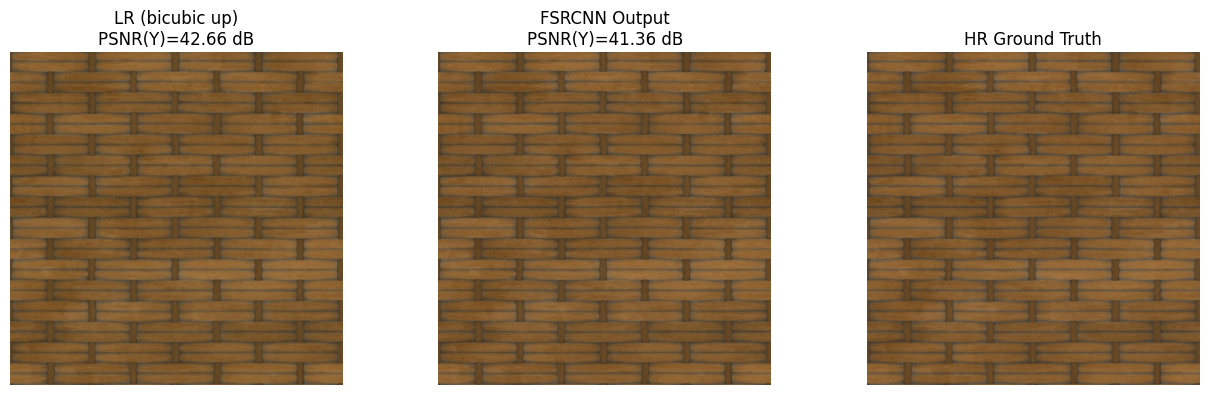

In [ ]:
def demo_image(lr_image_path, hr_image_path):
    lr_image = read_image(lr_image_path)
    bicubic_image = upscale(lr_image, SCALE)
    hr_image = read_image(hr_image_path)
    
    lr_image = gaussian_blur(lr_image, sigma=sigma)
    lr_image = rgb2ycbcr(lr_image)
    lr_image = norm01(lr_image)
    lr_image_up = F.interpolate(lr_image.unsqueeze(0), scale_factor=SCALE, mode="bicubic", align_corners=False).squeeze(0).clamp(0,1)
    
    lr_image = torch.unsqueeze(lr_image, dim=0)

    hr_image = rgb2ycbcr(hr_image)
    hr_image = norm01(hr_image)
    
    model = FSRCNN(SCALE, device)
    model.load_weights(ckpt_path)
    with torch.no_grad():
        lr_image = lr_image.to(device)
        sr_image = model.predict(lr_image)[0]

    sr_image = sr_image.cpu()

    psnr_lr = PSNR(hr_image, lr_image_up, max_val=1)
    psnr_sr = PSNR(hr_image, sr_image, max_val=1)

    ssim_lr = SSIM_Y(hr_image, lr_image_up)
    ssim_sr = SSIM_Y(hr_image, sr_image)
    
    sr_image = denorm01(sr_image)
    sr_image = sr_image.type(torch.uint8)
    sr_image = ycbcr2rgb(sr_image)

    hr_image = denorm01(hr_image)
    hr_image = hr_image.type(torch.uint8)
    hr_image = ycbcr2rgb(hr_image)

    lr_image_up = denorm01(lr_image_up)
    lr_image_up = lr_image_up.type(torch.uint8)
    lr_image_up = ycbcr2rgb(lr_image_up)

    fig, axes = plt.subplots(1, 3, figsize=(13, 4))
    axes[0].imshow(to_hwc_np(lr_image_up)); axes[0].set_title(f"LR (bicubic up)\nPSNR(Y)={psnr_lr:.2f} dB\nSSIM(Y)={ssim_lr:.2f}")
    axes[0].axis("off")
    axes[1].imshow(to_hwc_np(sr_image));    axes[1].set_title(f"FSRCNN Output\nPSNR(Y)={psnr_sr:.2f} dB\nSSIM(Y)={ssim_sr:.2f}")
    axes[1].axis("off")
    axes[2].imshow(to_hwc_np(hr_image));    axes[2].set_title("HR Ground Truth")
    axes[2].axis("off")
    plt.tight_layout(); plt.show()

    write_image('demo/lr.png', lr_image_up)
    write_image('demo/sr.png', sr_image)
    write_image('demo/hr.png', hr_image)

demo_image('dataset/test2.jpg', f'dataset/result2_{SCALE}x.jpg')